In [1]:
####################################################
#Note: I added shortcut to run all cells: ctrl-space
####################################################
# Load housing data
%run Load_csv
housing=load_housing_data()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0a2adcd30>]],
      dtype=object)

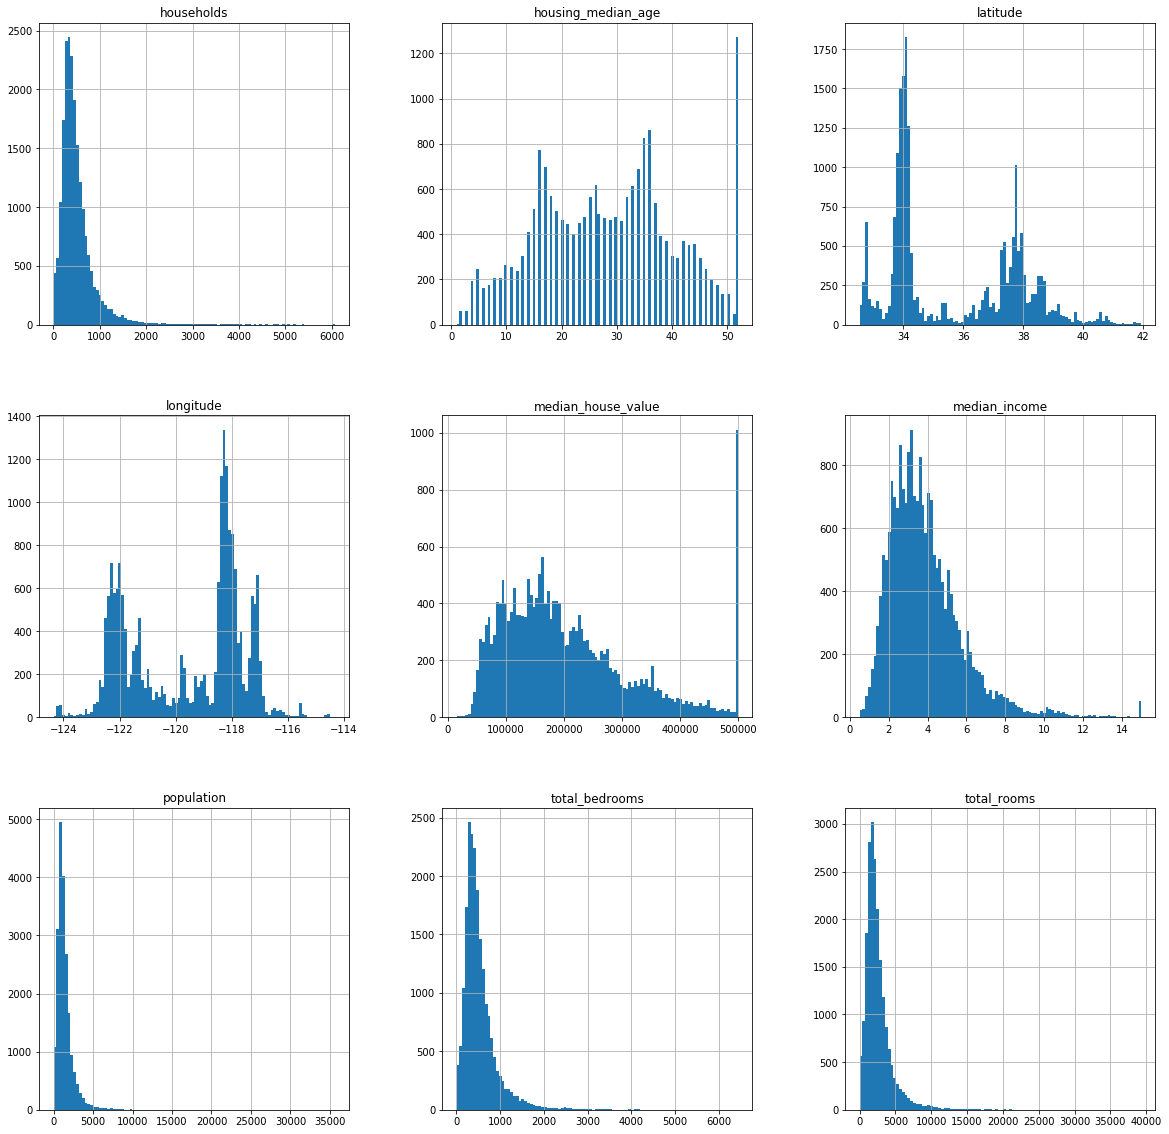

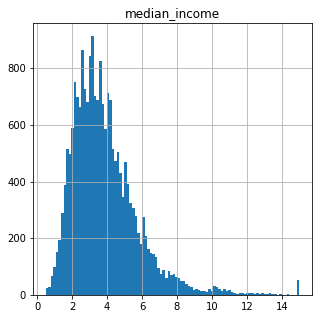

In [2]:
##############################################
#plot histograms 
##############################################
%matplotlib inline
import matplotlib.pyplot as plt

#Plot all columns
housing.hist(bins=100, figsize=(20,20))

#Plot only one column
housing.hist(column='median_income', bins=100, figsize=(5,5))


In [3]:
############################################
# create test set using pure random sampling method
#(don't see it! It will lead to data snooping bias 
#bec. of your amazing brain)
###############################################

import numpy as np

def split_train_set(data, test_ratio): 
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices] # this returns training set, test set

#call the function to split the housing data into test and training sets
train_set, test_set=split_train_set(housing, 0.2)
print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0a6fe4d68>]],
      dtype=object)

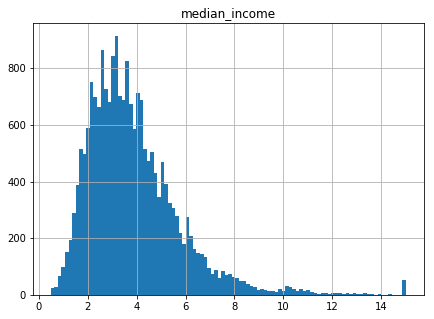

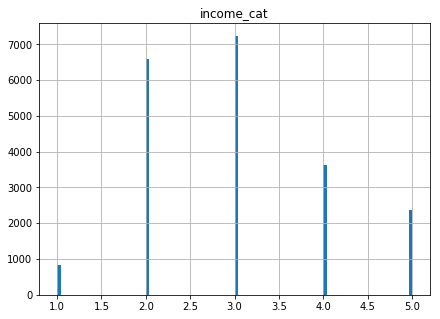

In [4]:
####################################################################################
#Script for stratified sampling into training and test sets based on median income 
#####################################################################################

### Distribute the median income into 5 categories

# Divide income by 1.5 and round-off using ceil command
housing["income_cat"]=np.ceil(housing["median_income"]/ 1.5)

# Merge all incomes with category higher than 5 into category 5
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True) 
# Explanation: if inplace=True, i.e housing[income_cat]<5, then keep it like that.
              # else assign it to category 5.0.

# Plot the median_income & the newly assigned income_cat based on median_income
housing.hist(column='median_income', bins=100, figsize=(7,5))
housing.hist(column='income_cat', bins=100, figsize=(7,5))



In [5]:
### Now perform stratified splitting of data into train set
### and test set using income_cat

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
### Check whether test set retains the general pattern seen in income_cat
### by plotting % of data wrt income_cat

strat_test_set["income_cat"].value_counts()/len(strat_test_set)


3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [6]:
### Now that you have finished stratified splitting of data, remove income_cat.

strat_test_set.info()
print('\n')

print('remove income_cat from test and training data')
print('\n')

for set_ in(strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 11 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4079 non-null float64
population            4128 non-null float64
households            4128 non-null float64
median_income         4128 non-null float64
median_house_value    4128 non-null float64
ocean_proximity       4128 non-null object
income_cat            4128 non-null float64
dtypes: float64(10), object(1)
memory usage: 387.0+ KB


remove income_cat from test and training data


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 10 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms  

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

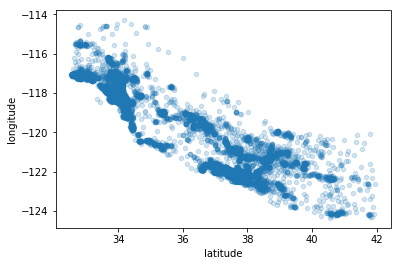

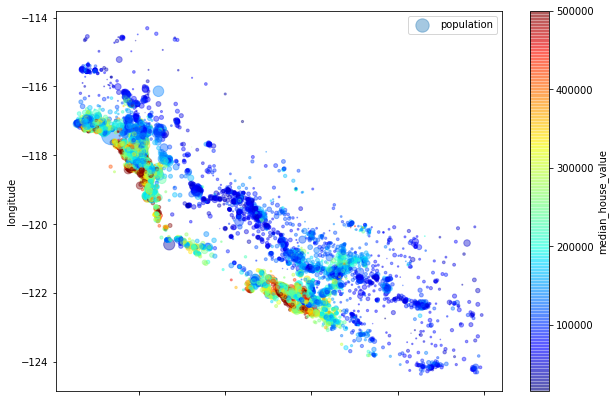

In [7]:
################################################
#Start playing with your training set
################################################

# First copy it 

housing = strat_train_set.copy()

# Plot 2-D distribution wrt geography. Alpha is blending 
#value. 0 is transparent, 1 is opaque

housing.plot(x="latitude", y="longitude", kind="scatter", alpha=0.2)

# plot a color map to see housing prices wrt 
#population and geography

#option s sets radius proportional to the quantity being plotted 
#(population in this case)

#Option c is for colormap. "Jet" is a colormap type.

housing.plot(x="latitude", y="longitude", kind="scatter", alpha=0.4,
            s=housing["population"]/100, label="population",figsize=(10,7), 
             c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True)

plt.legend()

#find correlations between median value and all other features

corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0d40769b0>,
      dtype=object)

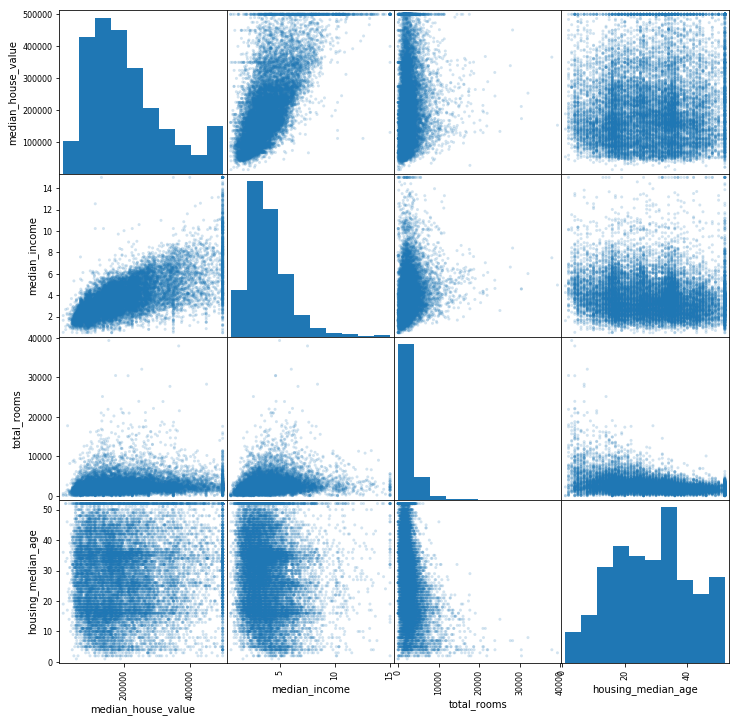

In [8]:
# Scattering matrix for studying correlations and finding 
# useful attribute combinations

from pandas.plotting import scatter_matrix 
attributes=["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,12), alpha=0.2)

In [9]:
##########################################
# Clean your data
#########################################

#First separate features from labels before transforming the features

# In the housing data, the label is median_house_value

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

# Fill missing values with median of each attribute using Imputer

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

#** Remove non-text attribute, which is "ocean_promixity" in this case
 
housing_num = housing.drop("ocean_proximity", axis=1)

#Now fit imputer to training data and store the medians
# in statistics_ instance. Statistics is a hyperparameter of Imputer

imputer.fit(housing_num)

imputer.statistics_

# Transform training set using the "trained" imputer

X = imputer.transform(housing_num)

# Put back X into a Pandas DataFrame

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

housing_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,533.998123,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,410.839621,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [10]:
# Convert categorical attributes to text

housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

housing_cat_encoded, housing_categories = housing_cat.factorize()
# housing_cat_encoded is now a purely numerical numpy array,
#housing_categories is a list of categories corresponding
# to the numerical array. 

housing_cat_encoded[:10]

print('ocean proximity categories are:')
print(housing_categories)
print("\n")
print('convert categories from text to number:')
print(housing_cat_encoded)
print("\n")

#But assigning numbers leads to incorrect relationships 
#between categories, e.g. 1 is closer to 2 than 4. 
#So, categorize using array of 0s and 1s instead! 
# This is called ONE-HOT ENCODING

from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
housing_cat_1hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

#housing_cat_1hot is a sparse matrix becoz non-diagonal elements are zero.
#Convert into array and print

print('Categories after one hot encoding:')
housing_cat_1hot.toarray()


ocean proximity categories are:
Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')


convert categories from text to number:
[0 0 1 ... 2 0 3]


Categories after one hot encoding:


/home/priyaroy/machine_learning/env/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [11]:
#Building custom transformers

# In this example, we define a custom transformer that will append 2 or 3 new columns
#'rooms_per_household', 'pop_per_household' and 'bedrooms_per_room' (optional) to the dataset

from sklearn.base import BaseEstimator, TransformerMixin #TransformerMixing base class has 3 methods:
                                                         #.fit(), transform() and fit_transform()
    
#Define indices
rm_ix, bedrm_ix, pop_ix, house_ix=3,4,5,6

class CombineAttributeAdder():
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        rooms_per_household=X[:,rm_ix]/X[:,house_ix]
        pop_per_household=X[:,pop_ix]/X[:,house_ix]
        bedrooms_per_room=X[:,bedrm_ix]/X[:,rm_ix]
        #Append 3 new columns to dataset X
        return np.c_[X, rooms_per_household,pop_per_household,bedrooms_per_room]
        
#Define object of class CombineAttributeAdder
att_adder=CombineAttributeAdder()
housing_extra_attribs=att_adder.transform(housing.values)
print(housing_extra_attribs.shape) #Dimensions of the array

(16512, 12)


In [12]:
#Construct a pipeline which works for numerical and categorical attributes

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion

class DataFrameSelector():
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)
#This gives a list of the headings of all columns of the housing_num dataframe

cat_attribs = ["ocean_proximity"]

#Define pipeline for numerical attributes

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombineAttributeAdder()),
    ('std_scaler', StandardScaler())
])

#Define pipeline that takes categorical attributes and converts them into numerical
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder())
])

#Unite the 2 pipelines

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

#Run the full pipeling on the housing dataframe

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)
print(housing_prepared[0,:])


(16512, 16)
  (0, 0)	-1.1560428086829155
  (0, 1)	0.7719496164846016
  (0, 2)	0.7433308916510305
  (0, 3)	-0.49323393384425046
  (0, 4)	-0.4454382074687401
  (0, 5)	-0.6362114070375079
  (0, 6)	-0.4206984222235789
  (0, 7)	-0.6149374443958345
  (0, 8)	-0.31205451913809157
  (0, 9)	-0.0864987054157523
  (0, 10)	0.15531753037148296
  (0, 11)	1.0


In [44]:
#Fine-tune hyperparameters using gridsearch or randomsearch

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from time import time

#Define grid of your hyperparameters

param_grid = {
    "n_estimators":[30,34,38], 
    "max_features":[8,10,12,16]
}

forest_reg_ft = RandomForestRegressor()

rand_search = RandomizedSearchCV(forest_reg_ft, param_distributions=param_grid, n_iter=20,\
                           cv=5,scoring='neg_mean_squared_error')

start = time()

rand_search.fit(housing_prepared, housing_labels)

print("RandomizedSearchCV took %.2f seconds for 20 iterations"% (time() - start))

print("Best combination of hyperparameters:")

rand_search.best_params_

/home/priyaroy/machine_learning/env/lib/python3.5/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV took 958.30 seconds for 20 iterations
Best combination of hyperparameters:


{'max_features': 8, 'n_estimators': 38}

In [47]:
# Check how well the fine-tuned classifier predicts labels for the test dataset
from sklearn.metrics import mean_squared_error

# Now prepare test data
test_set_1 = strat_test_set.drop("median_house_value", axis=1)
test_labels_1=strat_test_set["median_house_value"].copy()

test_prepared_1 = full_pipeline.fit_transform(test_set_1)

# Predict labels of test data with optimized Random Forest Classifier fit
final_model_1 = rand_search.best_estimator_

predictions_1 = final_model_1.predict(test_prepared_1)

final_mse_1 = mean_squared_error(predictions_1, test_labels_1)

print("Root mean square error between predicted and actual labels of test data:")
print(np.sqrt(final_mse_1))


Root mean square error between predicted and actual labels of test data:
67601.73041922874


In [14]:
#Find relative importance of each attribute from the fine-tuned fit

features_importances = rand_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

#type(features_importances)
sorted(zip(np.around(features_importances, decimals=3),attributes), reverse=True)

[(0.38, 'median_income'),
 (0.154, 'INLAND'),
 (0.113, 'pop_per_hhold'),
 (0.074, 'longitude'),
 (0.069, 'latitude'),
 (0.061, 'bedrooms_per_room'),
 (0.04, 'rooms_per_hhold'),
 (0.04, 'housing_median_age'),
 (0.015, 'total_rooms'),
 (0.015, 'population'),
 (0.014, 'total_bedrooms'),
 (0.014, 'households'),
 (0.005, '<1H OCEAN'),
 (0.003, 'NEAR OCEAN'),
 (0.002, 'NEAR BAY'),
 (0.0, 'ISLAND')]

In [15]:
#Define a class that selects top n attributes and drops the rest from the dataset


#Define a function which finds indices of n biggest elements of array 'arr'
def select_top_attribs(arr, n):
    top_indices = np.argpartition(arr, -n)[-n:]
    return top_indices

class top_attribs_selector(BaseEstimator, TransformerMixin):
    def __init__(self, arr, n): #Constructor
        self.top_indices = arr
        self.n = n
        
    def fit(self,X): #Here you are passing the data set as X because we usually do fit() 
        #and transform() together, and we need to supply X for transform().
        
        self.top_ind = select_top_attribs(self.top_indices, self.n)
        return self
    
    def transform(self, X):
        return X[:,self.top_ind]
        

In [16]:
#Define an instance of class top_attribs_selector and create a new matrix with only top n attributes
#and their values

A = top_attribs_selector(features_importances, 8)
type(A)
Y = A.fit_transform(housing_prepared)
print(np.around(Y[:1,], decimals=2))

  (0, 0)	-0.31
  (0, 1)	0.74
  (0, 2)	0.16
  (0, 3)	0.77
  (0, 4)	-1.16
  (0, 6)	-0.09
  (0, 7)	-0.61


In [17]:
#Check whether the above instance has correctly selected only top 8 attributes from housing_prepared dataset. 

Ind=select_top_attribs(features_importances, 8) #Create an array containing indices of top 8 attributes
print(np.around(housing_prepared[:1,Ind], decimals=2)) #print first row of values for the 8 attributes 
                                                        #((0,1), (0,2), (0,3)... (0,7))

# Comparing above result with the one below shows that it works!

  (0, 0)	-0.31
  (0, 1)	0.74
  (0, 2)	0.16
  (0, 3)	0.77
  (0, 4)	-1.16
  (0, 6)	-0.09
  (0, 7)	-0.61


In [50]:
# Add the attribute selector and prediction to the pipeline and publish a full pipeline version 2

#from sklearn.pipeline import Pipeline
#from sklearn.pipeline import FeatureUnion
# from sklearn.metrics import mean_squared_error
   
# Add top_attribs_selector to pipeline

full_pipeline_v2 = Pipeline([
    ("full_pipeline", full_pipeline),
    ('top_attrib_selector', top_attribs_selector(features_importances, 8))
])

#Transform original housing dataframe from scratch, including selecting top attributes, 
#then find optimal hyperparameters for Random Forest Classifier fit to the housing dataframe

housing_cleaned = full_pipeline_v2.fit_transform(housing)

#Find best params for Random Forest Clf fit to the cleaned up data. This is still training data. 

param_grid = {
    "n_estimators":[25,30,34,38], 
    "max_features":[4,6,8]
}

rand_search = RandomizedSearchCV(forest_reg_ft, param_distributions=param_grid, n_iter=20,\
                           cv=5,scoring='neg_mean_squared_error')

rand_search.fit(housing_cleaned, housing_labels)

print("New optimized hyperparameters for Random Forest Classifier, after selecting top 8 attributes:")
rand_search.best_params_

#The answer comes out to be {'max_features': 4, 'n_estimators': 38}, which is different from the previous 
#answer of {'max_features': 8, 'n_estimators': 38}

/home/priyaroy/machine_learning/env/lib/python3.5/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


New optimized hyperparameters for Random Forest Classifier, after selecting top 8 attributes:


{'max_features': 4, 'n_estimators': 38}

In [51]:
rand_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=38, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [52]:
from sklearn.metrics import mean_squared_error

# Now prepare test data
test_set = strat_test_set.drop("median_house_value", axis=1)
test_labels=strat_test_set["median_house_value"].copy()

test_prepared = full_pipeline_v2.fit_transform(test_set)

# Predict labels of test data with optimized Random Forest Classifier fit
final_model = rand_search.best_estimator_
predictions = final_model.predict(test_prepared)

final_mse = mean_squared_error(predictions, test_labels)

print("Root mean square error between predicted and actual labels of test data (cleaned up):")
print(np.sqrt(final_mse))


Root mean square error between predicted and actual labels of test data (cleaned up):
68072.35766382382
